In [1]:
import networkx as nx
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [2]:
V = range(6)
E = []

for i in V:
    if (i+1)%3 !=0:
        E.append((i,i+1))
    if i<3:
            E.append((i,i+3))

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)
edge_list = np.array([e for e in G.edges])

In [3]:
pos = nx.circular_layout(G)
pos[0] = (0.0, -0.90)
pos[1] = (0.5, -0.90)
pos[2] = (1., -0.90)
pos[3] = (0.0, 0.90)
pos[4] = (0.5, 0.90)
pos[5] = (1., 0.90)

{(0, 1): Text(0.25, -0.9, '6.0'),
 (0, 3): Text(0.0, 0.0, '8.0'),
 (1, 2): Text(0.75, -0.9, '2.0'),
 (1, 4): Text(0.5, 0.0, '4.0'),
 (2, 5): Text(1.0, 0.0, '4.0'),
 (3, 4): Text(0.25, 0.9, '10.0'),
 (4, 5): Text(0.75, 0.9, '6.0')}

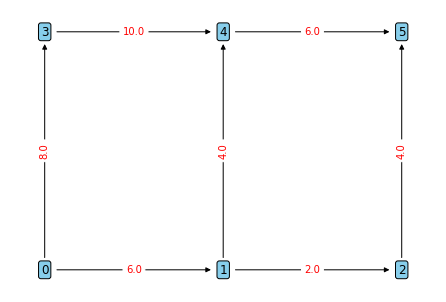

In [4]:
true_weights =  np.array([6.,8,2.,4.,4.,10.,6.])
for i,e in enumerate(G.edges()):
    G[e[0]][e[1]]['weight'] =  true_weights[i]


labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos=pos, with_labels=True,   node_shape="s",  node_color="none", bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'))
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels, font_color='red')

### The shortest path solutions is, 0-1-2-5.

In [5]:
###################################### Gurobi Shortest path Solver #########################################
class shortestpath_solver:
    def __init__(self,G= G):
        self.G = G
    
    def shortest_pathsolution(self, y):
        '''
        y: the vector of  edge weight
        '''
        A = nx.incidence_matrix(G,oriented=True).todense()
        b =  np.zeros(len(A))
        b[0] = -1
        b[-1] =1
        model = gp.Model()
        model.setParam('OutputFlag', 0)
        x = model.addMVar(shape=A.shape[1], vtype=gp.GRB.BINARY, name="x")
        model.setObjective(y @x, gp.GRB.MINIMIZE)
        model.addConstr(A @ x == b, name="eq")
        model.optimize()
        if model.status==2:
            return x.x
    def is_uniquesolution(self, y):
        '''
        y: the vector of  edge weight
        '''
        A = nx.incidence_matrix(G,oriented=True).todense()
        b =  np.zeros(len(A))
        b[0] = -1
        b[-1] =1
        model = gp.Model()
        model.setParam('OutputFlag', 0)
        x = model.addMVar(shape=A.shape[1], vtype=gp.GRB.BINARY, name="x")
        model.setObjective(y @x, gp.GRB.MINIMIZE)
        model.addConstr(A @ x == b, name="eq")
        model.setParam('PoolSearchMode', 2)
        model.setParam('PoolSolutions', 100)
        #model.PoolObjBound(obj)
        model.setParam('PoolGap', 0.0)
        model.optimize()
        self.model = model
        return model.SolCount<=1 

    def highest_regretsolution(self,y,y_true, minimize=True):
        mm = 1 if minimize else -1
        
        if self.is_uniquesolution(y):
            model = self.model
            return np.array(model.Xn).astype(np.float32), 0
        else:
            model = self.model
            sols = []
            for solindex in range(model.SolCount):
                model.setParam('SolutionNumber', solindex)
                sols.append(model.Xn)  
            sols = np.array(sols).astype(np.float32)
            # print(sols.dot(y_true))
            return sols[np.argmax(sols.dot(y_true)*mm, axis=0)], 1 


    def solution_fromtorch(self,y_torch):
        if y_torch.dim()==1:
            return torch.from_numpy(self.shortest_pathsolution( y_torch.detach().numpy())).float()
        else:
            solutions = []
            for ii in range(len(y_torch)):
                solutions.append(torch.from_numpy(self.shortest_pathsolution( y_torch[ii].detach().numpy())).float())
            return torch.stack(solutions)
    def highest_regretsolution_fromtorch(self,y_hat,y_true,minimize=True):
        if y_hat.dim()==1:
            sol, nonunique_cnt = self.highest_regretsolution( y_hat.detach().numpy(),
                     y_true.detach().numpy(),minimize  )
            return torch.from_numpy(sol).float(), nonunique_cnt
        else:
            solutions = []
            nonunique_cnt =0
            for ii in range(len(y_hat)):
                sol,nn = self.highest_regretsolution( y_hat[ii].detach().numpy(),
                     y_true[ii].detach().numpy(),minimize )
                solutions.append(torch.from_numpy(sol).float())
                nonunique_cnt += nn
            return torch.stack(solutions) , nonunique_cnt      
        
spsolver =  shortestpath_solver()

In [6]:
edge_list[np.where(spsolver.shortest_pathsolution(true_weights)==1)[0]]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-17


array([[0, 1],
       [1, 2],
       [2, 5]])

### Gurobi solution 0-1-2-5

### Define Precdicted weight: We're defining predicted weight $\hat{c}$ such a way that $2\hat{c} -c$ has symmetric solutions.

{(0, 1): Text(0.25, -0.9, '13.0'),
 (0, 3): Text(0.0, 0.0, '9.0'),
 (1, 2): Text(0.75, -0.9, '21.0'),
 (1, 4): Text(0.5, 0.0, '7.0'),
 (2, 5): Text(1.0, 0.0, '17.0'),
 (3, 4): Text(0.25, 0.9, '15.0'),
 (4, 5): Text(0.75, 0.9, '8.0')}

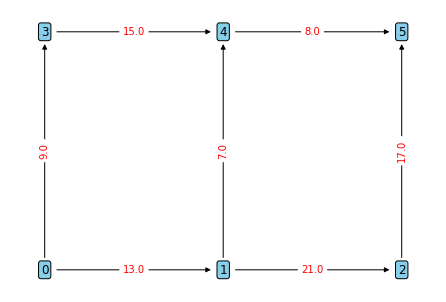

In [7]:
initial_predictedweights = np.array([13.,9.,21.,7.,17.,15.,8.]) 
for i,e in enumerate(G.edges()):
    G[e[0]][e[1]]['weight'] =  initial_predictedweights[i]

pos = nx.circular_layout(G)
pos[0] = (0.0, -0.90)
pos[1] = (0.5, -0.90)
pos[2] = (1., -0.90)
pos[3] = (0.0, 0.90)
pos[4] = (0.5, 0.90)
pos[5] = (1., 0.90)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos=pos, with_labels=True,   node_shape="s",  node_color="none", bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'))
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels, font_color='red')

In [8]:
edge_list[np.where(spsolver.shortest_pathsolution(initial_predictedweights )==1)[0]]

array([[0, 1],
       [1, 4],
       [4, 5]])

### The solutions with predicted cost: 0-1-4-5,

{(0, 1): Text(0.25, -0.9, '20.0'),
 (0, 3): Text(0.0, 0.0, '10.0'),
 (1, 2): Text(0.75, -0.9, '40.0'),
 (1, 4): Text(0.5, 0.0, '10.0'),
 (2, 5): Text(1.0, 0.0, '30.0'),
 (3, 4): Text(0.25, 0.9, '20.0'),
 (4, 5): Text(0.75, 0.9, '10.0')}

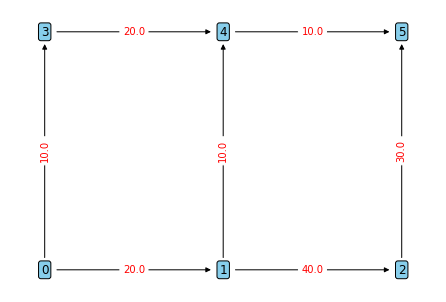

In [9]:

for i,e in enumerate(G.edges()):
    G[e[0]][e[1]]['weight'] =  2*initial_predictedweights[i] - true_weights[i]

pos = nx.circular_layout(G)
pos[0] = (0.0, -0.90)
pos[1] = (0.5, -0.90)
pos[2] = (1., -0.90)
pos[3] = (0.0, 0.90)
pos[4] = (0.5, 0.90)
pos[5] = (1., 0.90)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos=pos, with_labels=True,   node_shape="s",  node_color="none", bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'))
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels, font_color='red')

### The solutions of $2\hat{c}-c$ has two optimal solutions:  0-3-4-5 and 0-1-4-5

In [10]:
edge_list[np.where(spsolver.shortest_pathsolution(2*initial_predictedweights - true_weights)==1)[0]]

array([[0, 1],
       [1, 4],
       [4, 5]])

### Gurobi returns the solution 0-1-4-5

## Now I define two SPO object. The first one with the traditional SPO+ loss, the second one is considers the solution with  highest regret if $2\hat{c}-c$ has multiple solutions

In [11]:
def SPOLoss(solver, minimize=True):
    mm = 1 if minimize else -1
    class SPOLoss_cls(torch.autograd.Function):
        @staticmethod
        def forward(ctx, y_pred, y_true, sol_true):
       
            sol_hat = solver.solution_fromtorch(y_pred)
            sol_spo = solver.solution_fromtorch(2* y_pred - y_true)
            # sol_true = solver.solution_fromtorch(y_true)
            ctx.save_for_backward(sol_spo,  sol_true, sol_hat)
            return   mm*(  sol_hat - sol_true).dot(y_true)/( sol_true.dot(y_true) ) # changed to per cent rgeret

        @staticmethod
        def backward(ctx, grad_output):
            sol_spo,  sol_true, sol_hat = ctx.saved_tensors
            return mm*(sol_true - sol_spo), None, None
            
    return SPOLoss_cls.apply

def MaximumregretSPOLoss(solver, minimize=True):
    mm = 1 if minimize else -1
    class MaximumregretSPOLoss_cls(torch.autograd.Function):
        @staticmethod
        def forward(ctx, y_pred, y_true, sol_true):
       
            # sol_hat = solver.solution_fromtorch(y_pred)
            sol_hat,  nonunique_cnt = solver.highest_regretsolution_fromtorch(y_pred,y_true,minimize=True)
            sol_spo, _ = solver.highest_regretsolution_fromtorch(2* y_pred - y_true,y_true,minimize=True)
            # sol_true = solver.solution_fromtorch(y_true)
            ctx.save_for_backward(sol_spo,  sol_true, sol_hat)
            return   mm*(  sol_hat - sol_true).dot(y_true)/( sol_true.dot(y_true) ) # changed to per cent rgeret

        @staticmethod
        def backward(ctx, grad_output):
            sol_spo,  sol_true, sol_hat = ctx.saved_tensors
            return mm*(sol_true - sol_spo), None, None
            
    return MaximumregretSPOLoss_cls.apply

In [12]:
import torch
from torch.autograd import Variable

dtype = torch.FloatTensor

true_w = Variable(torch.from_numpy(true_weights).type(dtype), requires_grad=False)

pred_w1 = Variable( torch.from_numpy(initial_predictedweights).type(dtype),requires_grad=True)
sol_w = spsolver.solution_fromtorch(true_w)


### First train the normal SPO+ loss

In [13]:
learning_rate = 0.2
criterion = SPOLoss(spsolver)
for ep in range(10):
    loss = criterion(pred_w1,true_w, sol_w)

    loss.backward()
    print("Subgradient in epoch {} ".format(ep), pred_w1.grad)
    

    # Update weights using gradient descent; w1.data and w2.data are Tensors,
    # w1.grad and w2.grad are Variables and w1.grad.data and w2.grad.data are
    # Tensors.
    pred_w1.data -= learning_rate * pred_w1.grad.data
#     print("Updated Coefficients",pred_w1.data)
    
    pred_w1.grad.data.zero_()
    

Subgradient in epoch 0  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 1  tensor([ 1., -1.,  1.,  0.,  1., -1., -1.])
Subgradient in epoch 2  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 3  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 4  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 5  tensor([ 1., -1.,  1.,  0.,  1., -1., -1.])
Subgradient in epoch 6  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 7  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 8  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 9  tensor([ 1., -1.,  1.,  0.,  1., -1., -1.])


### Next train the alternatiev way

In [14]:
pred_w2 = Variable( torch.from_numpy(initial_predictedweights).type(dtype),requires_grad=True)



In [15]:
learning_rate = 0.1
criterion = MaximumregretSPOLoss(spsolver)
for ep in range(10):
    loss = criterion(pred_w2,true_w, sol_w)

    loss.backward()
    print("Subgradient in epoch {} ".format(ep), pred_w2.grad)

    # Update weights using gradient descent; w1.data and w2.data are Tensors,
    # w1.grad and w2.grad are Variables and w1.grad.data and w2.grad.data are
    # Tensors.
    pred_w2.data -= learning_rate * pred_w2.grad.data
    
    pred_w2.grad.data.zero_()
    
    

Subgradient in epoch 0  tensor([ 1., -1.,  1.,  0.,  1., -1., -1.])
Subgradient in epoch 1  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 2  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 3  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 4  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 5  tensor([ 1., -1.,  1.,  0.,  1., -1., -1.])
Subgradient in epoch 6  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 7  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 8  tensor([ 0.,  0.,  1., -1.,  1.,  0., -1.])
Subgradient in epoch 9  tensor([ 1., -1.,  1.,  0.,  1., -1., -1.])


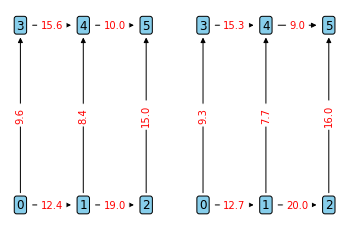

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()

for i,e in enumerate(G.edges()):
    G[e[0]][e[1]]['weight'] = round( pred_w1[i].item(),3)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos=pos, with_labels=True,   node_shape="s",  node_color="none",
        bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'), ax=ax[0])
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels, font_color='red', ax=ax[0])

for i,e in enumerate(G.edges()):
    G[e[0]][e[1]]['weight'] = round( pred_w2[i].item(),3)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos=pos, with_labels=True,   node_shape="s",  node_color="none",
        bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'), ax=ax[1])
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels, font_color='red', ax=ax[1])

plt.show()

### The left plot is with normal SPO, the right plot with SPO with maximal regret. Both have same solution as hown below.

### Although the subgradeint differes in the first epoch, but eventually not much difference.

In [ ]:
edge_list[np.where(spsolver.shortest_pathsolution(pred_w1.detach().numpy() )==1)[0]]

In [ ]:
edge_list[np.where(spsolver.shortest_pathsolution(pred_w2.detach().numpy() )==1)[0]]